In [12]:
import numpy as np
import pandas as pd
from pygimli.meshtools import readGmsh
import pygimli as pg

from scipy.spatial import distance_matrix
from scipy.interpolate import griddata
from itertools import combinations
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt

from scipy.spatial import Delaunay, cKDTree
from pygimli.physics import ert
from ertoolbox import inversion


In [14]:
csv = '../data/cs_694.csv'
data = pd.read_csv(csv)
print(data)



       Unnamed: 0    x   z   IC
0               0    0   0  1.0
1               1    0   1  1.0
2               2    0   2  1.0
3               3    0   3  1.0
4               4    0   4  4.0
...           ...  ...  ..  ...
16379       16379  511  27  1.0
16380       16380  511  28  1.0
16381       16381  511  29  1.0
16382       16382  511  30  1.0
16383       16383  511  31  3.0

[16384 rows x 4 columns]


In [15]:
data.columns =['a', 'x', 'z', 'salinity'] #for now these columns are nesseccary!!

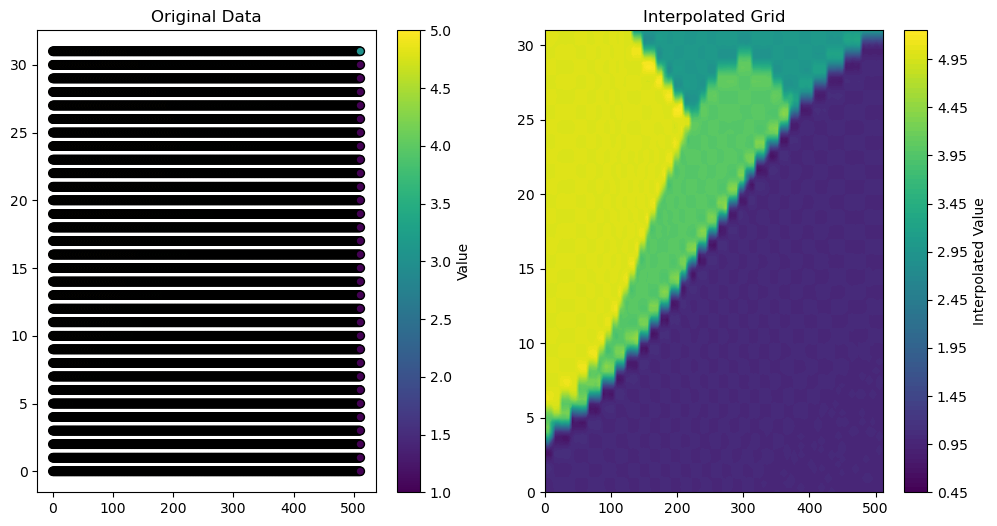

In [16]:
# Define grid parameters
x_min, x_max = data['x'].min(), data['x'].max()
z_min, z_max = data['z'].min(), data['z'].max()
grid_size = 100  # Number of grid points along each axis

# Create a regular grid
x_grid = np.linspace(x_min, x_max, grid_size)
z_grid = np.linspace(z_min, z_max, grid_size)
X_grid, Z_grid = np.meshgrid(x_grid, z_grid)
Y_grid = np.zeros(np.shape(X_grid))

# Stack grid data
xyz = np.column_stack([X_grid.flatten(),Z_grid.flatten()])

# Prepare data for interpolation
points = data[['x', 'z']].values
values = data['salinity'].values

# Interpolate
grid_values = griddata(points, values, (X_grid, Z_grid), method='cubic')

# Plot original points
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(data['x'], data['z'], c=data['salinity'], cmap='viridis', edgecolor='k')
plt.title('Original Data')
plt.colorbar(label='Value')

# Plot interpolated grid
plt.subplot(1, 2, 2)
plt.contourf(X_grid, Z_grid, grid_values, levels=100, cmap='viridis')
plt.title('Interpolated Grid')
plt.colorbar(label='Interpolated Value')
# X_grid = data['x']
# Z_grid = data['z']
# grid_values = data['salinity']

plt.show()

26/09/24 - 16:16:08 - pyGIMLi - INFO - Data error estimate (min:max)  0.010389313075835967 : 0.038191567351933166


relativeError set to a value > 0.5 .. assuming this is a percentage Error level dividing them by 100


26/09/24 - 16:23:11 - pyGIMLi - INFO - Found 31682 regions.
26/09/24 - 16:23:11 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (0) set to background.
26/09/24 - 16:23:11 - pyGIMLi - INFO - Creating forward mesh from region infos.
26/09/24 - 16:23:12 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
26/09/24 - 16:23:14 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 64449 Cells: 126728 Boundaries: 96130
26/09/24 - 16:23:16 - pyGIMLi - INFO - Use median(data values)=2.0580889091938728
26/09/24 - 16:23:16 - pyGIMLi - INFO - Created startmodel from forward operator: 31681, min/max=2.058089/2.058089
26/09/24 - 16:23:16 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x0000025754EAC130>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x000002570A2905E0>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x000002575F4CEED0>
min/max (data): 1.01/3.67
min/max (error): 1.04%/3.82%
min/max (start model): 2.06/2.06
--------------------------------------------------------------------------------
inv.iter 0 ... chi² = 1291.68
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =    0.94 (dPhi = 99.92%) lam: 20.0


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.94)                   #
################################################################################


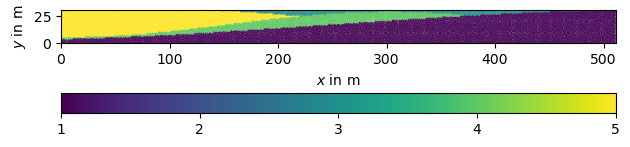

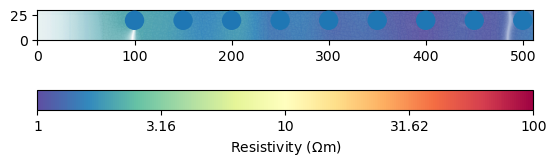

In [19]:
# Create 2D Pygimli  mesh
mesh = pg.Mesh(2)

cs = []
cr = []

# Make nodes for all datapoints
for p in points:
    c = mesh.createNode((p[0],p[1]))
    cs.append(c)

# Triangulate points into mesh with triangles
tri = Delaunay(points)
triangles = tri.simplices

# Calculate centroids of the triangles
centroids = np.array([np.mean(points[tri.simplices[i]], axis=0) for i in range(len(tri.simplices))])

# Find closest grid point to the triangle
tree = cKDTree(points)
distances, indices = tree.query(centroids)

# Add value to the grid cell
triangle_values = values[indices]

# Add triangles to mesh object
tlist = []
for t in range(0,len(triangles)):
    mesh.createTriangle(cs[triangles[t][0]],cs[triangles[t][1]],cs[triangles[t][2]], marker = t)
    tlist = np.append(tlist,t)

# Add boundaries
mesh.createNeighborInfos()

# Plot mesh with values
ax, cb = pg.show(mesh, data=triangle_values)

# Define electrode positions TODO
EZ = [20,20,20,20,20,20,20,20,20]
EX = [100,150,200,250,300,350,400,450,500]
electrodes = [[x, y] for x, y in zip(EX, EZ)]

# Create measurement scheme
scheme_dd = ert.createData(elecs=electrodes, schemeName='dd')

# Make simulation data
simdata = ert.simulate(
         mesh=mesh, scheme=scheme_dd, res=triangle_values, noiseLevel=1,
                    noiseAbs=1e-6, seed=1337
    )

#Inverse for check
inversion_dd_1 = inversion(simdata, mesh, saveresult=False)
